# Movie Box Office revenue predictor


## Authors: Christopher Budd, Mustafa Syed, and Jayant Varma 

### Objective: 
To predict the revenue generated by a movie given its other features such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, etc.



**Dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing** Kindly download the dataset on your local machine and run it accordingly (see how we ran it under 'Loading the dataset')

# Movies daily updated dataset description:

**Attributes for the dataset:**
The below attributes are copied **AS IS** from the original dataset website https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data 

1. id	--> TMDB id

2. title	--> Title of the movie

3. genres	--> Genres are separated by'-'

4. original_language	--> The language the movie was made in

5. overview	    --> short description of movie

6. popularity   --> TMDB metric, in depth description can be found here, https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/discussion/400671 

7. production_companies	--> '-' separated production company

8. release_date     --> movie release date

9. budget	--> budget of the movie

10. revenue	    --> Revenue generated by the movie

11. runtime	    --> duration of the movie

12. status	--> status (Released, or planned, or other)

13. tagline	    --> tagline

14. vote_average	--> average of votes given by tmdb users

15. vote_count	       --> vote counts

16. credits	        --> '-' separated cast if movie

17. keywords	    --> '-' separated keywords that desciption of movie

18. poster_path	    --> poster image

19. backdrop_path	--> background images

20. recommendations --> '-' separated recommended movie id


**Missing values:** There exist missing values in multiple features of the above dataset as we'll soon see


**Duplicated values:** 
There exist duplicated values in multiple features of the above dataset as we'll soon see


# 1: Looking at the big picture, framing the problem, and business practicality

### Frame the problem
1. Supervised learning – training examples are labeled.
2. A regression task – predict a value (Revenue).
3. Batch learning 
    - Small data set
    - No continuous flow of data coming into the system
    - No need to adjust to changing data rapidly

### Big Picture/Business objective:
At the end of the day every business wants to know how much revenue they can generate given the all production inputs. Our project solves this problem for the movie industry. See objective below.

### Objective: 
To predict the revenue generated by a movie given its other featuers such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, and recommendations.


# Initial set up

In [105]:
# Import libraries

import sklearn
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [106]:
url="https://raw.githubusercontent.com/Jayant1Varma/Movie-Box-Office-predictor/Model-Training/input/modified_data.csv"
movies = pd.read_csv(url, sep=',') 
# Please note: The file is massive, and not be referred online. You MUST download the file on your local machine from https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=drive_link (MAKE SURE YOU ONLY USE YOUR YORK UNIVERSITY GOOGLE ACCOUNT!!!)

# 2 First impressions on the dataset, graphs of the EDA, and patterns found


Note: We use only the dataset from January 1st 2015 until Nov. 5th 2023

In [107]:
# Convert 'release_date' to datetime format
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Create a mask for filtering dates
mask = (movies['release_date'] >= '2015-01-01') & (movies['release_date'] <= '2023-11-05')

# Apply the mask to filter rows
movies = movies[mask]

# Sort the DataFrame based on 'release_date'
movies = movies.sort_values(by='release_date', ascending=False)

one of the issues that we noticed with the dataset was our dataset had a lot of zeroes within the target values. To remedy this we sampled the same quantity of nonzero revenues from the set of zero revenues to create a more compact and useable dataset


In [201]:

mask=(movies['revenue']!=0)
df1=movies[mask]

mask=(movies['revenue']==0)
df2=movies[mask].sample(n=len(df1),random_state=42)

movies=pd.concat((df1,df2))

#### Use head() to look at the first 5 rows

In [202]:
movies.head()

,original_language,popularity,budget,revenue,runtime,vote_average,vote_count
106736,en,0.671,100000000,100000000,149.0,0.000,0
87264,en,0.893,100000000,100000000,149.0,0.000,0
13,en,2058.036,20000000,221800000,110.0,8.116,1869
199,en,192.682,175000000,362113,118.0,7.008,244
56,en,492.742,30000000,46561805,111.0,5.494,82


#### Use describe() method to see a summary of the numerical attributes.


Note: 
- Since count of id = count of budget and count of revenue, we know our data for predicting revenue is complete in a one to one mapping between id and revenue. The data rows exist, however the values may need preprocessing
- Parts of this data make little sense, for example, the maximum run time is 1.5 years if we take the unit to be in seconds. This clearly means, a lot of data cleaning, and preprocessing is required. Since 75% of movies are 90 time units long, we will arbitrarily take 150 units as the maximum length allowed, and delete all instances that run longer than this. (see preprocessing).
- Revenue could be negative, as seen from the 'min' case.

In [110]:
movies.describe()

,id,popularity,release_date,budget,revenue,runtime,vote_average,vote_count
count,10150.000000,10150.000000,10150,1.015000e+04,1.015000e+04,10005.000000,10150.000000,10150.000000
mean,597785.055468,16.095839,2018-10-13 06:44:54.147783168,6.497085e+06,2.164677e+07,72.142129,4.180909,428.668276
min,10317.000000,0.600000,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,440483.750000,0.600000,2017-01-01 00:00:00,0.000000e+00,0.000000e+00,15.000000,0.000000,0.000000
50%,583760.500000,1.368000,2018-09-30 00:00:00,0.000000e+00,5.000000e-01,88.000000,5.600000,2.000000
75%,753064.250000,7.524000,2020-07-29 18:00:00,2.278000e+03,1.179560e+06,106.000000,7.000000,64.000000
max,968130.000000,8763.998000,2023-11-03 00:00:00,5.400000e+08,2.799439e+09,480.000000,10.000000,28462.000000
std,192477.344692,160.860057,NaN,2.699171e+07,1.124980e+08,49.968983,3.433212,1692.980986


#### Use info() to get a quick description of the data, the total number of rows, each attribute’s type, and the number of non-null values.

In [111]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10150 entries, 106736 to 16738
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    10150 non-null  int64         
 1   title                 10150 non-null  object        
 2   genres                8782 non-null   object        
 3   original_language     10150 non-null  object        
 4   overview              9251 non-null   object        
 5   popularity            10150 non-null  float64       
 6   production_companies  6792 non-null   object        
 7   release_date          10150 non-null  datetime64[ns]
 8   budget                10150 non-null  int64         
 9   revenue               10150 non-null  int64         
 10  runtime               10005 non-null  float64       
 11  status                10150 non-null  object        
 12  tagline               3637 non-null   object        
 13  vote_average    

In [112]:
corr_matrix = movies.corr(numeric_only=True)
corr_matrix

,id,popularity,budget,revenue,runtime,vote_average,vote_count
id,1.000000,-0.017689,-0.245262,-0.202186,-0.414176,-0.355562,-0.289799
popularity,-0.017689,1.000000,0.239218,0.181140,0.083024,0.077340,0.109184
budget,-0.245262,0.239218,1.000000,0.761236,0.235372,0.178553,0.686760
revenue,-0.202186,0.181140,0.761236,1.000000,0.190372,0.156350,0.757061
runtime,-0.414176,0.083024,0.235372,0.190372,1.000000,0.466975,0.232742
vote_average,-0.355562,0.077340,0.178553,0.156350,0.466975,1.000000,0.205403
vote_count,-0.289799,0.109184,0.686760,0.757061,0.232742,0.205403,1.000000


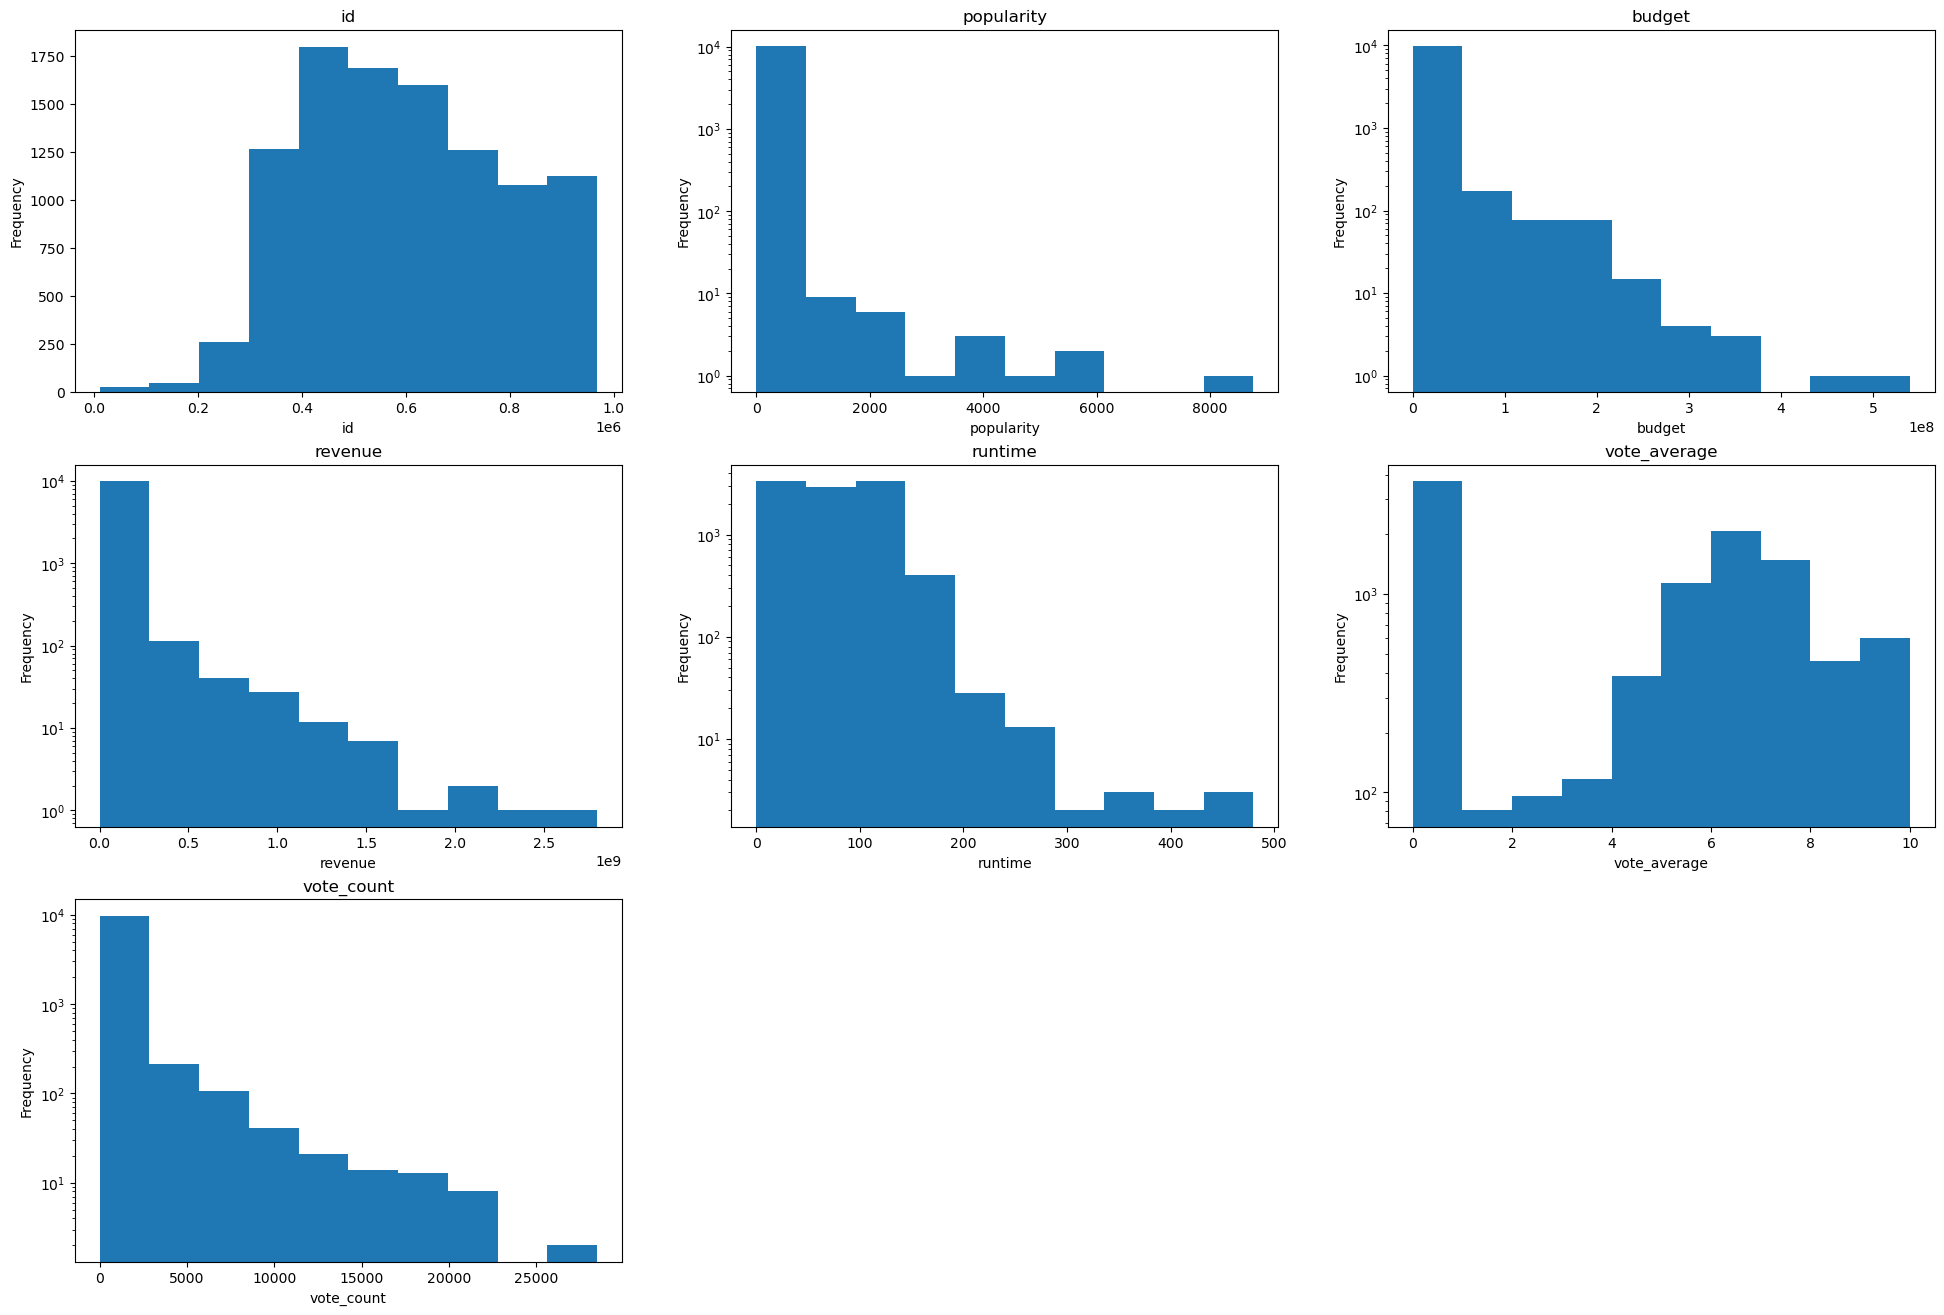

In [113]:
import matplotlib.pyplot as plt

numerical_columns = movies.select_dtypes(include='number').columns

###
num_plots = len(numerical_columns)

### 3 rows and 3 columns of subplots
rows = 3 
cols = 3  


### make sub
fig, axes = plt.subplots(rows, cols, figsize=(24, 16))

##
for i, column in enumerate(numerical_columns):
    row = i // cols  
    col = i % cols   
    movies[column].plot(kind='hist', ax=axes[row, col])
    axes[row, col].set_title(column)
    
    # Access and modify x-axis properties
    axes[row, col].set_xlabel(numerical_columns[i])
    # You can set ticks, limits, etc., for the x-axis similarly
    
    # Access and modify y-axis properties
    axes[row, col].set_ylabel('Frequency')
    # You can set ticks, limits, etc., for the y-axis similarly
    
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

### set scale to logarithmic to display the data
axes[0,1].set_yscale('log')
axes[0,2].set_yscale('log')
axes[1,0].set_yscale('log')
axes[1,1].set_yscale('log')
axes[1,2].set_yscale('log')
axes[2,0].set_yscale('log')

plt.show()

### Curious note: Usually, one may presume that the greater the budget of the movie, the better revenue it may generate. So let's put this to the test:

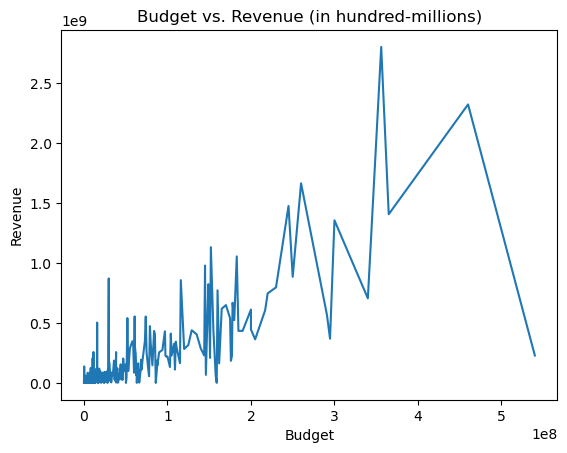

In [115]:
# Plot budget vs. revenue generated

budgetVsRevenue = sns.lineplot(x="budget", y="revenue", data=movies, errorbar=None)
# Set labels and title
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget vs. Revenue (in hundred-millions)')

plt.show()

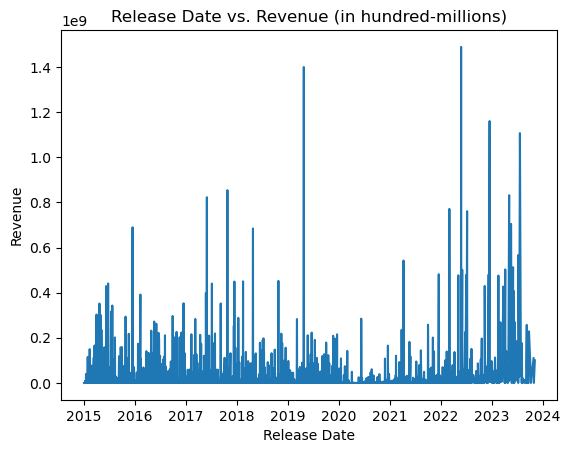

In [116]:

releaseDateVsRevenue = sns.lineplot(x="release_date", y="revenue", data=movies, errorbar=None)
plt.xlabel('Release Date')
plt.ylabel('Revenue')
plt.title('Release Date vs. Revenue (in hundred-millions)')
plt.show()

Observation: As you can see, it is not necessarily the case that higher the budget, the more revenue is generated. For better visualization, we must clean this data to scale the x-axis (i.e., budget) to better see the correlation

Text(0, 0.5, 'revenue')

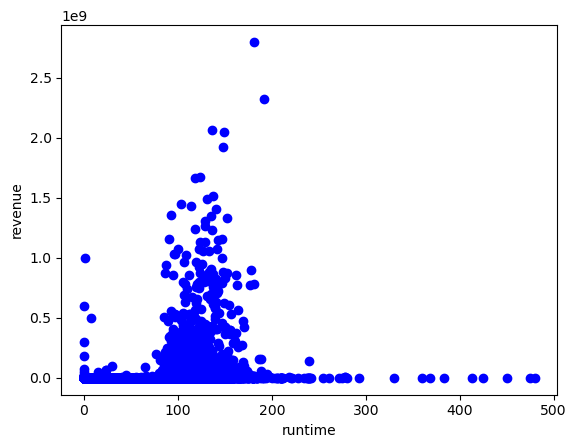

In [117]:
x_axis = movies["runtime"]
y_axis = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

Observation: clearly, we need to get rid of the right most value as it is ruining the data plot. We need feature scaling after that. 
### Check the data cleaning part, we have removed the outliers by using a threshold for our movie runtime. We plot this graph again for better interpretations.

# 3 Preprocessing: Preparing data for Machine Learning tasks


## 3.1. - Data cleaning

Recall from above, that one runtime value is extraordinarily big. We will remove this outlier now.

In [118]:
# Assuming the threshold for high runtime is 150 minutes long
threshold_runtime = 150

# Create a boolean mask indicating which rows have runtime below or equal to the threshold
mask = movies['runtime'] <= threshold_runtime

# now, our dataframe contains only the rows with runtime below or equal to the threshold
movies = movies[mask]



Text(0, 0.5, 'revenue')

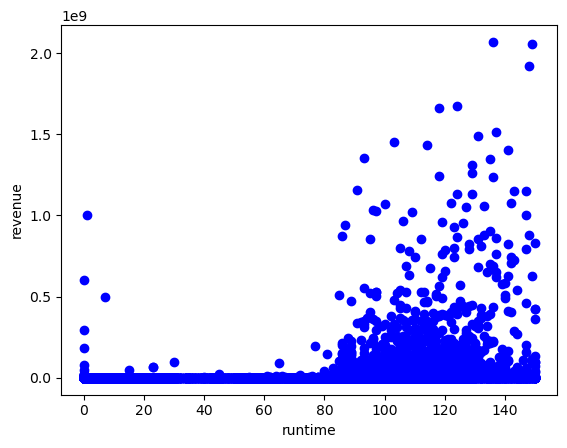

In [119]:
# We now show how our earlier plot becomes so much better:

x_axis = movies["runtime"]
y_axis = movies["revenue"]

# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

3.1.1-  Checking for duplicates, and dropping them:

In [120]:
movies.duplicated().sum()

0

In [121]:
movies.drop_duplicates(inplace=True)

3.1.2 - Handle the missing values:

In [122]:
# Find the number of missing values in each column as a fraction out of total instances

movies.isna().sum()/len(movies)

id                      0.000000
title                   0.000000
genres                  0.131549
original_language       0.000000
overview                0.080906
popularity              0.000000
production_companies    0.330005
release_date            0.000000
budget                  0.000000
revenue                 0.000000
runtime                 0.000000
status                  0.000000
tagline                 0.636644
vote_average            0.000000
vote_count              0.000000
credits                 0.174678
keywords                0.492743
recommendations         0.706227
dtype: float64

In [123]:
''' Genres is not put in a format such that we can analyse it since the datatype is a String
we will make the datatype into a list such that our data pipeline can separate each category
into different classes'''

### all the datatypes are split by a '-' so we can unsplit them and make them into a list
movies['Genres_list'] = movies['genres'].str.split('-')

### even while converted alot of the movies do not have genres therefore I use a lambda equation to set these to empty lists
movies['Genres_list'] = movies['Genres_list'].apply(lambda x: x if isinstance(x, list) else [])

### show the updated/new feature
movies['Genres_list']


106736    [Music, Fantasy, Drama, Romance]
87264     [Music, Fantasy, Drama, Romance]
13                       [Horror, Mystery]
199                      [Crime, Thriller]
56                                [Horror]
                        ...               
49444                             [Action]
15761                              [Drama]
10985           [Drama, Mystery, Thriller]
33149            [Action, Science Fiction]
16738                      [Drama, Action]
Name: Genres_list, Length: 9715, dtype: object

### Removing unnecessary features ### 

We removed a lot of unimportant fields for various reasons, for the first set of features we are unable to use them to predict revenue as they are in the form of a String and we came to the conclusion that feature engineering was not possible. For generes it is necessary to remove it since we have remade it into 'Genres list' finally for id the property is entirely irrelevant. 

In [124]:
### drop the string features as they cannot be interpreted effectively
movies.drop(labels=['recommendations'], axis=1, inplace=True)
movies.drop(labels=['tagline'], axis=1, inplace=True)
movies.drop(labels=['keywords'], axis=1, inplace=True)
movies.drop(labels=['production_companies'], axis=1, inplace=True)
movies.drop(labels=['overview'], axis=1, inplace=True)
movies.drop(labels=['status'], axis=1, inplace=True)
movies.drop(labels=['credits'], axis=1, inplace=True)
movies.drop(labels=['title'], axis=1, inplace=True)

### cannot process the datetime feature in regression model, feature engineering would be necessary
movies.drop(labels=['release_date'], axis=1, inplace=True)

### drop this because genres_list has been generated 
movies.drop(labels=['genres'],axis=1,inplace=True)

### completely irrelevant to the data
movies.drop(labels=['id'], axis=1, inplace=True)

#### For the remaining missing values, we will fill them with the mean if it is a numerical value and the most frequent if it is a categorical column

#### We will do this through creating a pipeline, that will also scale the features and perform encoding in the next step.

### 3.1.3 Creating a pipeline that will:

1. Fill in the missing numerical values with the mean using a SimpleImputer

2. Scale the numerical columns using StandardScaler. Do not scale the target

3. Fill in the missing categorical values with the most_frequent value using SimpleImputer

4. Encode the categorical columns using OneHotEncoder


In [125]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [126]:
# The MultiLabelBinarizer is used to process list based data and encode them into different categoriess
mlb = MultiLabelBinarizer()

# Transform the 'Genres_list' column into a binary representation
genres_encoded = mlb.fit_transform(movies['Genres_list'])

# Create a DataFrame with the encoded genres
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Mulilabel binarizer converts the columns into that of datatype object and not float (which is used by the regression models) 
genres_encoded_df=genres_encoded_df.astype(float)

# shows all the different genres that are encoded into the dataframe (less than you'd think for over 10,000 movies
genres_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9715 entries, 0 to 9714
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Action           9715 non-null   float64
 1   Adventure        9715 non-null   float64
 2   Animation        9715 non-null   float64
 3   Comedy           9715 non-null   float64
 4   Crime            9715 non-null   float64
 5   Documentary      9715 non-null   float64
 6   Drama            9715 non-null   float64
 7   Family           9715 non-null   float64
 8   Fantasy          9715 non-null   float64
 9   History          9715 non-null   float64
 10  Horror           9715 non-null   float64
 11  Music            9715 non-null   float64
 12  Mystery          9715 non-null   float64
 13  Romance          9715 non-null   float64
 14  Science Fiction  9715 non-null   float64
 15  TV Movie         9715 non-null   float64
 16  Thriller         9715 non-null   float64
 17  War           

In [243]:
# drop the 'Genres_list' so that it is not processed within the pipeline 
movies.drop(labels=['Genres_list'], axis=1, inplace=True)

KeyError: "['Genres_list'] not found in axis"

In [128]:
# Create the cat and num columns
# Get a list of column names from the 'movies' DataFrame that are of numerical data types.
# Get a list of column names from the 'movies' DataFrame that are not of numerical data types.

num_cols = movies.select_dtypes(include='number').columns.to_list()
cat_cols = movies.select_dtypes(exclude='number').columns.to_list()


# Exclude the target from numerical columns
num_cols.remove("revenue")


# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),  OneHotEncoder(sparse_output=False))

# Use ColumnTransformer to set the estimators and transformations

preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [129]:
num_cols

['popularity', 'budget', 'runtime', 'vote_average', 'vote_count']

In [130]:
cat_cols

['original_language']

In [131]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['popularity', 'budget', 'runtime',
                                  'vote_average', 'vote_count']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['original_language'])])

In [132]:
# Apply the preprocessing pipeline on the dataset                 
movies_prepared = preprocessing.fit_transform(movies)

# Scikit-learn strips the column headers, so just add them back on afterwards
feature_names=preprocessing.get_feature_names_out()
movies_prepared = pd.DataFrame(data=movies_prepared, columns=feature_names)

# Concatenated the two encoded datasets together that were independently processed 
movies_prepared=pd.concat([movies_prepared,genres_encoded_df],axis=1)
movies_prepared


# 4 Training and evaluation of 3 Machine Learning Algorithms, findings, and result comparison

## 4.1 Training Split

In [133]:
from sklearn.model_selection import train_test_split

# split the training and test data
x = movies_prepared.drop(["remainder__revenue"], axis=1)
y = movies_prepared['remainder__revenue']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7772, 113) (7772,) (1943, 113) (1943,)


In [134]:
x

,num__popularity,num__budget,num__runtime,num__vote_average,num__vote_count,cat__original_language_af,cat__original_language_am,cat__original_language_ar,cat__original_language_as,cat__original_language_az,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,-0.094558,3.694321,1.732558,-1.216063,-0.254967,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.093202,3.694321,1.732558,-1.216063,-0.254967,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12.474843,0.545648,0.888910,1.156114,0.869207,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.078526,6.646202,1.061966,0.832263,-0.108205,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.911733,0.939232,0.910542,0.389745,-0.205645,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710,-0.089249,-0.241520,1.083598,0.537641,-0.253764,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9711,-0.069931,-0.241520,0.650958,0.566869,-0.233915,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9712,-0.057792,-0.241520,0.672590,0.508413,-0.222487,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9713,-0.084264,-0.241520,1.061966,-1.216063,-0.254967,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [135]:
y

0       100000000.0
1       100000000.0
2       221800000.0
3          362113.0
4        46561805.0
           ...     
9710            0.0
9711            0.0
9712            0.0
9713            0.0
9714            0.0
Name: remainder__revenue, Length: 9715, dtype: float64

## 4.1. - Training of 3 ML algorithms
- Algorithm 1: LinearRegression no regularization
- Algorithm 2: XGBRegression
- Algorithm 3: RandomForestRegressor

### Algorithm 1: Linear Regression no regularization

In [136]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [137]:
lr_y_predict = lr_model.predict(X_test)

from sklearn.metrics import mean_absolute_error as mae
lr_mae=mae(y_test, lr_y_predict)
lr_mae

1672854068333229.5

### Algorthm 2: 

In [139]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [140]:
xgb_y_predict = xgb_model.predict(X_test)
xgb_mae=mae(y_test, xgb_y_predict)
xgb_mae

11534870.398466399

### Algorthm 3 

In [141]:
from sklearn.linear_model import Ridge
RidgeRegression = Ridge(alpha=1)
ridge_model = RidgeRegression.fit(X_train, y_train)

In [142]:
ridge_y_predict = ridge_model.predict(X_test)
ridge_mae = mae(y_test, ridge_y_predict)
ridge_mae

17224350.092105087

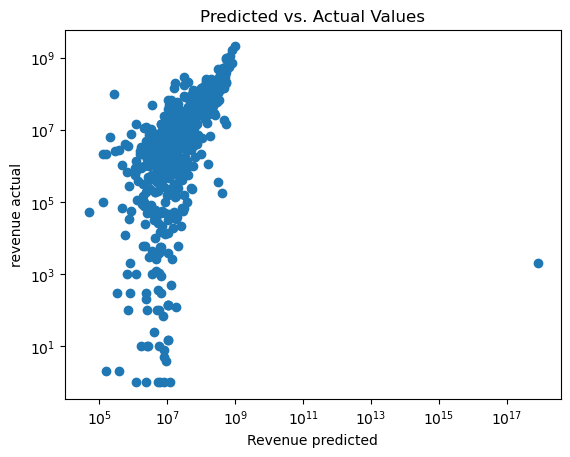

In [143]:
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.xscale('log')
plt.yscale('log')
plt.title("Predicted vs. Actual Values")
plt.show()

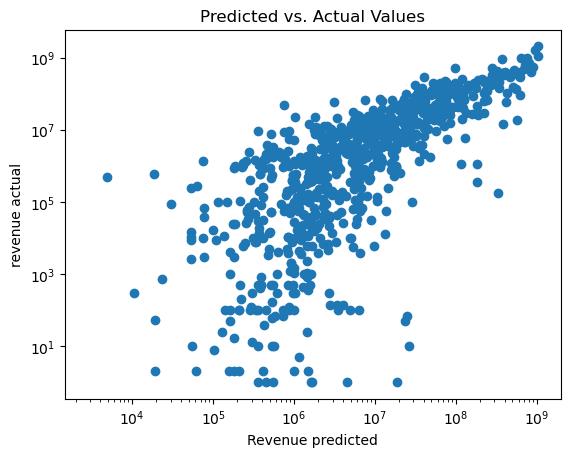

In [144]:
plt.scatter(xgb_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.xscale('log')
plt.yscale('log')
plt.title("Predicted vs. Actual Values")
plt.show()

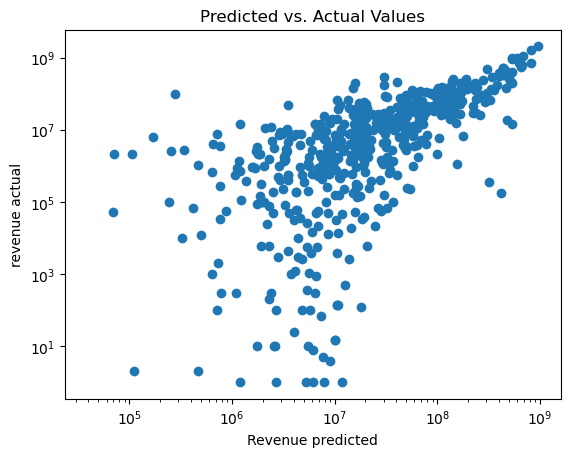

In [145]:
plt.scatter(ridge_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.xscale('log')
plt.yscale('log')
plt.title("Predicted vs. Actual Values")
plt.show()

## 4.2. - Analysis of findings


In [147]:
print(f'Linear Regression: {lr_mae}')
print(f'XGB Regression: {xgb_mae}')
print(f'Ridge Regression: {ridge_mae}')

Linear Regression: 1672854068333229.5
XGB Regression: 11534870.398466399
Ridge Regression: 17224350.092105087


XGBoost Regression has the lowest mean absolute error value therefore, it our best performing algorithm

# 5 - Three Graphs for the best performance algorithm

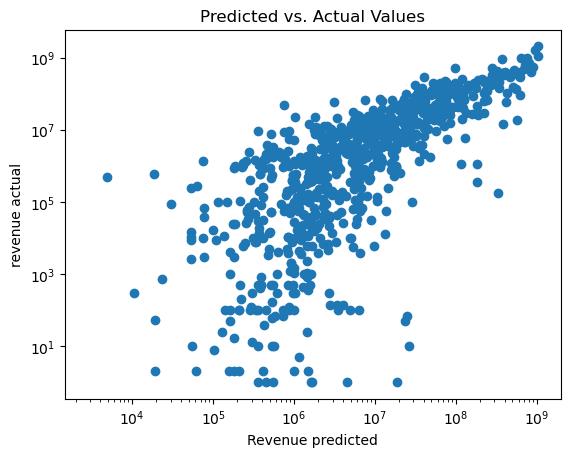

In [194]:
plt.scatter(xgb_y_predict, y_test)  # y is your actual target values
plt.xlabel("Revenue predicted")
plt.ylabel("revenue actual")
plt.title("Predicted vs. Actual Values")
plt.xscale('log')
plt.yscale('log')
plt.show()


n = len(xgb_y_predict)  # Number of data points
index = np.arange(n)  # Create an array of indices

bar_width = 0.35  # Width of the bars

plt.bar(index, xgb_y_predict, bar_width, label='Predicted Revenue')
plt.bar(index + bar_width, y_test, bar_width, label='Actual Revenue')

plt.xlabel('Data Point Index')
plt.ylabel('Revenue')
plt.title('Predicted vs. Actual Revenue')
plt.xticks(index + bar_width / 2, (str(i) for i in range(n)))  # X-axis labels
plt.yscale('log')  # Setting y-axis to logarithmic scale
plt.legend()

plt.tight_layout()
plt.show()

# 6-Limitations of the project

## Many zero's for budget and revenue

The biggest limitation with this project was the data provide, as it left a lot to be desired. Firstly, when we were thinking of the idea for how to implement a revenue prediction model that would predict well for a movie that would come out, we would never foresee a lack of revenue and budget data for recent movies, however this became the biggest issue. Much of our data lacked proper budget and revenue values, we remedied this by sampling are zero and non-zero data.Even with our solution having more precise and accurate data would make the model significantly better.

## Feature Data engineering

Many of the features that are useable require very complex data engineering for example in the case of something like production company or credits we would need to convert it from a String format to a more useable format. While the dataset has a massive amount of data, much of this data is not useable in its base form.

## Lack of focus on more complex and equally relevant factors

There are many factors that our model does not focus on that could have been very relevant such as the company that produced it, the amount of money in advertisting that was spent on it and potentially even the country it was initially released to. A lot of very complex factors have significant bearing on the amount of money that a movie earns. While our model predicts in spite of the lack of features it uses, I'd argue that with more features it would be more precise and predict more accurately.

# Appendix 1:

Empty unless we used someone else's code, then we cite it here

# Appendix 2: 

### Github repository link: https://github.com/Jayant1Varma/Movie-Box-Office-predictor.git 

**Original dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing**